<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x134ED7B11F0>
(512, 512, 4)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


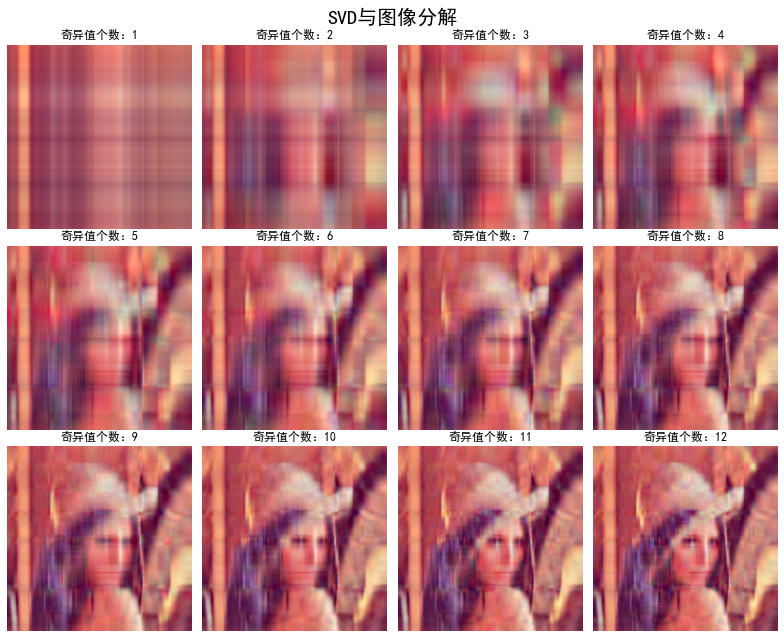

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint


def restore1(sigma, u, v, K):  # 奇异值、左特征向量、右特征向量
    m = len(u)
    n = len(v[0])
    a = np.zeros((m, n))
    for k in range(K):
        uk = u[:, k].reshape(m, 1)
        vk = v[k].reshape(1, n)
        a += sigma[k] * np.dot(uk, vk)
    a[a < 0] = 0
    a[a > 255] = 255
    # a = a.clip(0, 255)
    return np.rint(a).astype('uint8')


def restore2(sigma, u, v, K):  # 奇异值、左特征向量、右特征向量
    m = len(u)
    n = len(v[0])
    a = np.zeros((m, n))
    for k in range(K+1):
        for i in range(m):
            a[i] += sigma[k] * u[i][k] * v[k]
    a[a < 0] = 0
    a[a > 255] = 255
    return np.rint(a).astype('uint8')


if __name__ == "__main__":
    A = Image.open("E:\\Ai\\ImagePerch\\lena.jpg", 'r')
    print(A)
    output_path = r'./SVD_Output'
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    a = np.array(A)
    print(a.shape)
    K = 50
    u_r, sigma_r, v_r = np.linalg.svd(a[:, :, 0])
    u_g, sigma_g, v_g = np.linalg.svd(a[:, :, 1])
    u_b, sigma_b, v_b = np.linalg.svd(a[:, :, 2])
    plt.figure(figsize=(11, 9), facecolor='w')
    mpl.rcParams['font.sans-serif'] = ['simHei']
    mpl.rcParams['axes.unicode_minus'] = False
    for k in range(1, K+1):
        print(k)
        R = restore1(sigma_r, u_r, v_r, k)
        G = restore1(sigma_g, u_g, v_g, k)
        B = restore1(sigma_b, u_b, v_b, k)
        I = np.stack((R, G, B), axis=2)
        Image.fromarray(I).save('%s\\svd_%d.png' % (output_path, k))
        if k <= 12:
            plt.subplot(3, 4, k)
            plt.imshow(I)
            plt.axis('off')
            plt.title('奇异值个数：%d' % k)
    plt.suptitle('SVD与图像分解', fontsize=20)
    plt.tight_layout()
    # plt.subplots_adjust(top=0.9)
    plt.show()


In [5]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
import cv2

In [16]:
import cv2
import numpy as np

def stackImages(scale, imgArray):
    """
        将多张图像压入同一个窗口显示
        :param scale:float类型，输出图像显示百分比，控制缩放比例，0.5=图像分辨率缩小一半
        :param imgArray:元组嵌套列表，需要排列的图像矩阵
        :return:输出图像
    """
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver


#读取图片
src = cv2.imread("E:\\Ai\\ImagePerch\\bin.png")
img = src.copy()

#灰度
img_1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#二值化
ret, img_2 = cv2.threshold(img_1, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#腐蚀
kernel = np.ones((20, 20), int)
img_3 = cv2.erode(img_2, kernel, iterations=1)

#膨胀
kernel = np.ones((3, 3), int)
img_4 = cv2.dilate(img_3, kernel, iterations=1)

#找到硬币中心
contours, hierarchy = cv2.findContours(img_4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]

#标识硬币
cv2.drawContours(img, contours, -1, (0, 0, 255), 5)

#显示图片
cv2.putText(img, "count:{}".format(len(contours)), (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(src, "src", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_1, "gray", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_2, "thresh", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_3, "erode", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
cv2.putText(img_4, "dilate", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 3)
imgStack = stackImages(1, ([src, img_1, img_2], [img_3, img_4, img]))
cv2.imshow("imgStack", imgStack)
cv2.waitKey(0)


-1

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
 
 
"""
    项目主题：硬币检测和计数的设计与实现
"""
import cv2
import numpy as np
 
 
def stackImages(scale, imgArray):
    """
        将多张图像压入同一个窗口显示
        :param scale:float类型，输出图像显示百分比，控制缩放比例，0.5=图像分辨率缩小一半
        :param imgArray:元组嵌套列表，需要排列的图像矩阵
        :return:输出图像
    """
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        hor_con = [imageBlank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver
 
 
'1. 初始操作'
src = cv2.imread("E:\\Ai\\ImagePerch\\bin.png")
img = src.copy()
 
'2. 图像预处理——灰度化'
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
'3. 图像预处理——二值化'
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
 
'4. 图像预处理——消除特有噪声（形态学变换）'
# kernel = np.ones((3, 3), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel, iterations=2)
opening = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations=3)
 
'根据距离变换的性质，经过简单的运算，即可用于细化字符的轮廓和查找物体质心（中心）。'
'5. 寻找前景区域——分离连接物体distanceTranform()参数含义：1）二值图像     2）距离变换类型   3）距离变换的掩膜模板'
# DIST_L2：简单欧几里得距离 Δ = sqrt((x1 - x2)² + (y1 - y2)²)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
 
'6. 找到未知区域'
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
print(ret)
sure_fg = np.uint8(sure_fg)
 
'7. 找到硬币中心（轮廓查找）findContours()参数含义：1）8位图像   2）轮廓查找模式    3）查找近似方法'
contours, hierarchy = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
 
'8. 绘制硬币中心（轮廓绘制）drawContours()参数含义：1）原图     2）轮廓点坐标   3）轮廓索引    4）线条颜色  5）线条粗细'
cv2.drawContours(img, contours, -1, (0, 0, 255), 3)
 
'9. 完成显示'
'''
    *知识点回顾：
    putText()参数含义：1）图像  2）需显示的文本  3）坐标  4）文本字体  5）文本尺寸百分比   6）文本颜色   7）文本粗细
'''
cv2.putText(img, "count:{}".format(len(contours)), (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
cv2.putText(src, "srcImg", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
cv2.putText(gray, "gray", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 3)
cv2.putText(thresh, "thresh", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 3)
cv2.putText(opening, "open", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 3)
cv2.putText(sure_fg, "fg", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 3)
 
imgStack = stackImages(0.7, ([src, gray, thresh], [opening, sure_fg, img]))
cv2.imshow("imgStack", imgStack)
cv2.waitKey(0)

30.56005859375


-1

In [70]:
import cv2
import pyzbar.pyzbar as pyzbar
import numpy
from PIL import Image, ImageDraw, ImageFont


def decodeDisplay(img_path):

    img_data = cv2.imread(img_path)
    # 转为灰度图像
    gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    barcodes = pyzbar.decode(gray)

    for barcode in barcodes:

        # 提取条形码的边界框的位置
        # 画出图像中条形码的边界框
        (x, y, w, h) = barcode.rect
        cv2.rectangle(img_data, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # 条形码数据为字节对象，所以如果我们想在输出图像上
        # 画出来，就需要先将它转换成字符串
        barcodeData = barcode.data.decode("utf-8")
        barcodeType = barcode.type
        #不能显示中文
        # 绘出图像上条形码的数据和条形码类型
        #text = "{} ({})".format(barcodeData, barcodeType)
        #cv2.putText(imagex1, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,5, (0, 0, 125), 2)

        #更换为：
        img_PIL = Image.fromarray(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
        # 参数（字体，默认大小）
        font = ImageFont.truetype('msyh.ttc', 35)
        # 字体颜色（rgb)
        fillColor = (0, 255, 255)
        # 文字输出位置
        position = (x, y-50)
        # 输出内容
        str = barcodeData
        # 需要先把输出的中文字符转换成Unicode编码形式(  str.decode("utf-8)   )

        draw = ImageDraw.Draw(img_PIL)
        draw.text(position, str, font=font, fill=fillColor)
        # 使用PIL中的save方法保存图片到本地
        img_PIL.save('E:\\Ai\\ImagePerch\\1.jpg', 'jpeg')
        # 向终端打印条形码数据和条形码类型
        print("{0}: {1}".format(barcodeType, barcodeData))

if __name__ == '__main__':
    decodeDisplay("E:\\Ai\\ImagePerch\\black.png")


EAN13: 9787115279460
